In [25]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
import sys
sys.path.append("/home/yufan") 
#from perturbgene.data_utils import GeneTokenizer, read_h5ad_file
import scanpy as sc
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd

In [62]:
adata = sc.read_h5ad("chunk3562_stress_tumor_repair.h5ad")
adata

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10000 × 58604
    obs: 'soma_joinid_column', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', 'GDF15_embedding_status', 'NPY_embedding_status', 'TFPI2_embedding_status', 'MEG3_embedding_status', 'WIF1_embedding_status', 'HACE1_embedding_status', 'SGK1_embedding_status', 'LRRC3B_embedding_status', 'MKRN1_embedding_status', 'THY1_embedding_status', 'LZTFL1_embedding_status', 'DUSP26_embedding_status', 'TMEFF2_embedding_status', 'PAX1_embedding_status', 'CXXC4_embedding_status', 'MXI1_embedding_s

In [10]:
def label_to_float(label):
    label = label.replace("_"," ").replace("-",' ')
    if 'year' in label:
        if "-" in label:
            return float(label.split(' ')[0])
        elif label == "under 1 year old human stage":
            return 1.0
        else:
            return float(label.split(' ')[0])
    elif 'month' in label:
        # Convert month to weeks (approximate)
        if "LMP" not in label:
            return float(label.split(' ')[0])/12
        elif label == "eighth LMP month human stage":
            return 8/12
        elif label == "fifth LMP month human stage":
            return 5/12
        # Add more cases as needed
    elif 'week' in label:
        return float(label.split(" ")[0].replace("th",'').replace("st",""))/52
    return -1.0

### Figure 2: Age Prediction vs chronological age label

In [20]:
def plot_z_score(y_test,y_pred, fig_name = "plots/age_prediction_z_score.png"):
    # Calculate Pearson correlation
    r, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation (r): {r:.2f}')

    # Calculate the z-scored age gap - (age gap - mean of age gap)/sd of age gap
    age_gap = y_pred - y_test
    mean_age_gap = np.mean(age_gap)
    std_age_gap = np.std(age_gap)
    z_scored_age_gap = (age_gap - mean_age_gap) / std_age_gap

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, hue=z_scored_age_gap, palette='coolwarm', edgecolor='k', alpha=0.6, legend=False)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    norm = plt.Normalize(z_scored_age_gap.min(), z_scored_age_gap.max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='z-scored age gap')
    plt.xlabel('chronological age',fontsize=18)
    plt.ylabel('predicted age',fontsize=18)
    plt.title(f'age prediction',fontsize=18)
    plt.text(0.05, 0.95, f'r = {r:.2f}', transform=plt.gca().transAxes, 
            fontsize=18, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))
    plt.savefig(fig_name, dpi=300, bbox_inches='tight') 
    plt.show()

Pearson correlation (r): 0.96


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


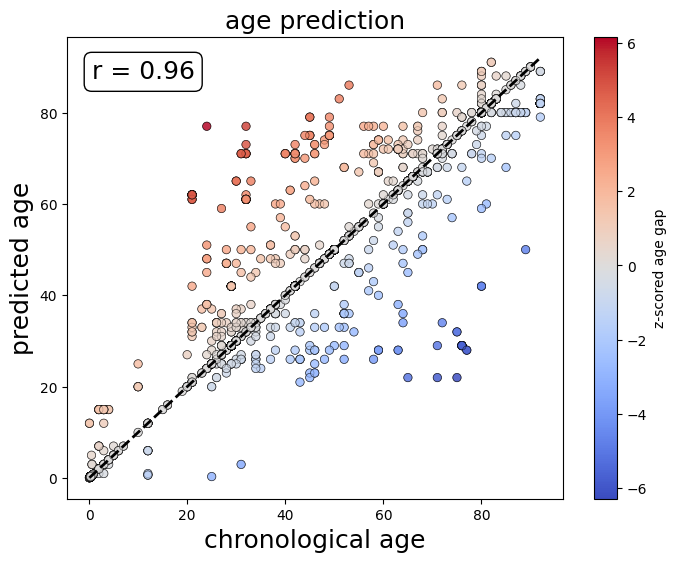

In [21]:
adata_cut = adata[adata.obs["disease"] == "normal"]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred)

Pearson correlation (r): 0.98


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


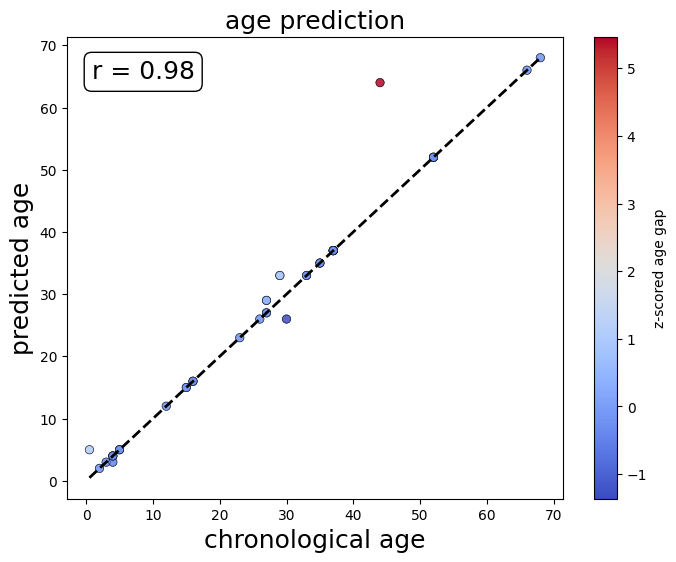

In [23]:
tissue = "respiratory airway"
adata_cut = adata[(adata.obs["disease"] == "normal") & (adata.obs["tissue"] == tissue)]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred, f"plots/{tissue}_age_prediction_z_score.png")

Pearson correlation (r): 0.62


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


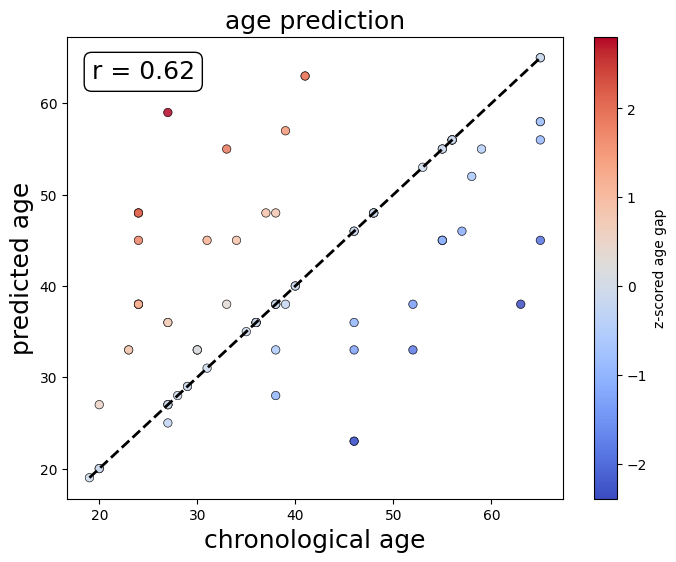

In [24]:
tissue = "breast"
adata_cut = adata[(adata.obs["disease"] == "normal") & (adata.obs["tissue"] == tissue)]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred, f"plots/{tissue}_age_prediction_z_score.png")

### Fig 3: cell-type-specific age predictions

In [56]:
adata_cut = adata[adata.obs["disease"] == "normal"]
data = pd.DataFrame({
    'Predicted Age': adata_cut.obs["prediction_age"].apply(label_to_float).to_list(),
    'Ground Truth Age': adata_cut.obs["development_stage"].apply(label_to_float).to_list(),
    'Cell Type': adata_cut.obs["cell_type"].to_list()
})

# Filter out invalid values
data = data[(data['Predicted Age'] != -1) & (data['Ground Truth Age'] != -1)]
unique_cell_types = data['Cell Type'].unique()
for cell_type in unique_cell_types:
    subset = data[data['Cell Type'] == cell_type]
    if len(subset) > 10:  # Filter for sufficient data
        plt.figure(figsize=(12, 8))
        sns.regplot(x="Ground Truth Age", y="Predicted Age", data=subset, ci=None, scatter_kws={"s": 20, "color": "blue"}, line_kws={"color": "black"})
        
        # Calculate correlation
        correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]
        if pd.notna(correlation):
            plt.text(0.1, 0.9, f'R = {correlation:.2f}', transform=plt.gca().transAxes, fontsize=18, verticalalignment='top')
        
        # Set labels and titles
        plt.xlabel("Chronological age",fontsize=18)
        plt.ylabel("Predicted chronological age",fontsize=18)
        plt.title(f'Age Prediction vs Ground Truth for Cell Type: {cell_type}',fontsize=18)
        output_dir = "cell_type"
        # Save plot
        plt.savefig(os.path.join(output_dir, f'{cell_type.replace(" ","_").replace("/","_")}_plot.png'), bbox_inches='tight')
        plt.close()

/tmp/ipykernel_11513/2189127356.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]


/tmp/ipykernel_11513/3911272767.py:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]


<Figure size 1200x800 with 0 Axes>

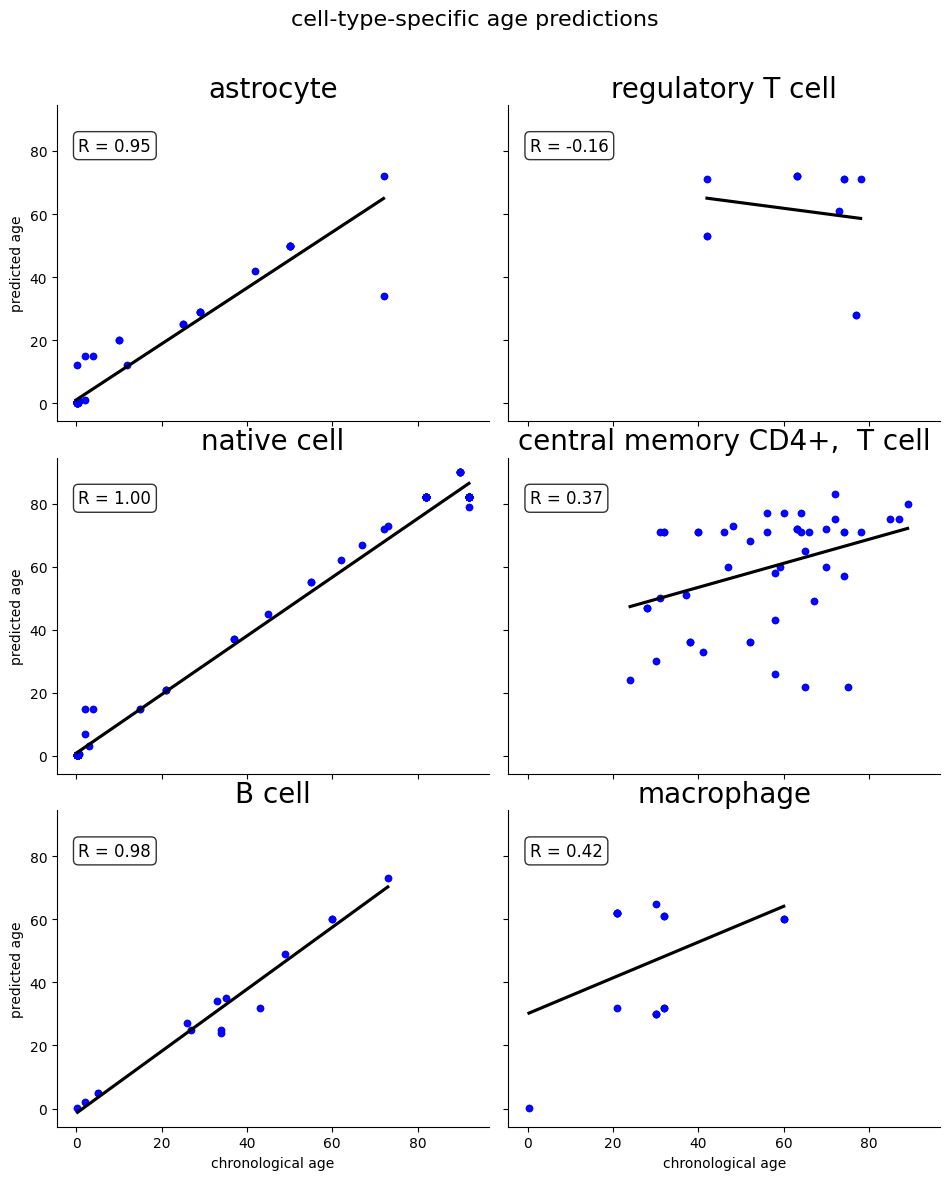

In [59]:
adata_cut = adata[adata.obs["disease"] == "normal"]
data = pd.DataFrame({
    'Predicted Age': adata_cut.obs["prediction_age"].apply(label_to_float).to_list(),
    'Ground Truth Age': adata_cut.obs["development_stage"].apply(label_to_float).to_list(),
    'Cell Type': adata_cut.obs["cell_type"].to_list()
})
data = data[(data['Predicted Age'] != -1) & (data['Ground Truth Age'] != -1)]
valid_cell_types = ['astrocyte','regulatory T cell','native cell',
                    'central memory CD4-positive, alpha-beta T cell',
                    'B cell','macrophage']
filtered_data = data[data['Cell Type'].isin(valid_cell_types)]


# plot
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(filtered_data, col="Cell Type", col_wrap=2, height=4, aspect=1.2, col_order=valid_cell_types)
g.map(
    sns.regplot, 
    "Ground Truth Age", 
    "Predicted Age", 
    ci=None, 
    scatter_kws={"s": 20, "color": "blue"}, 
    line_kws={"color": "black"}
)
for ax in g.axes.flat:
    title = ax.get_title()
    cell_type = title.split(" = ")[-1] 
    formatted_title = cell_type.replace("-positive", "+").replace("alpha-beta",'') # rename to make it shorter for this cell type
    ax.set_title(formatted_title, fontsize=20)
    subset = filtered_data[filtered_data["Cell Type"] == cell_type]
    correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]
    if pd.notna(correlation):
        ax.text(
            0.05, 0.9, 
            f'R = {correlation:.2f}', 
            transform=ax.transAxes, 
            fontsize=12, 
            verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.8), 
            color="black"
        )
g.set_axis_labels("chronological age", "predicted age")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("cell-type-specific age predictions", fontsize=16)
plt.savefig("plots/cell-type-specific age predictions.png", dpi=300, bbox_inches='tight')
plt.show()

### Figure 4: Similarity between cell type token and age token

In [87]:
cosine_similarity_dict = {}
adata_cut = adata[adata.obs["disease"] == "normal"]
embedding_1 = adata_cut.obsm["cell_type_embeddings"]
embedding_2 = adata_cut.obsm["development_stage_embeddings"]
cell_types = adata_cut.obs["cell_type"]

# calculate cosine similiarity group by cell types
for cell_type in cell_types.unique():
    cell_indices = adata_cut.obs["cell_type"] == cell_type
    subset_embedding_1 = embedding_1[cell_indices]
    subset_embedding_2 = embedding_2[cell_indices]
    similarity_matrix = cosine_similarity(subset_embedding_1, subset_embedding_2)
    diagonal_similarity = np.mean(np.diag(similarity_matrix))#.tolist()
    #mean_similarity = similarity_matrix
    cosine_similarity_dict[cell_type] = diagonal_similarity
cosine_similarity_df = pd.DataFrame.from_dict(cosine_similarity_dict, orient='index', columns=["Cosine Similarity"])
#cosine_similarity_df.to_csv("cosine_similarity_by_cell_type.csv")
cosine_similarity_df

,Cosine Similarity
neuron,0.391692
"CD8-positive, alpha-beta T cell",0.286552
"double-positive, alpha-beta thymocyte",0.399359
"CD4-positive, alpha-beta T cell",0.314032
glutamatergic neuron,0.418133
...,...
enterocyte of epithelium of large intestine,0.583123
Mueller cell,0.318002
non-classical monocyte,0.277068
kidney interstitial fibroblast,0.398278


In [84]:
cosine_similarity_dict

{'neuron': array([0.38967496, 0.54184055, 0.44049412, 0.3560239 , 0.30261323,
        0.4270132 , 0.37361577, 0.3619501 , 0.18216309, 0.33334905,
        0.17279984, 0.18523043, 0.36175168, 0.50230885, 0.31690687,
        0.3064411 , 0.545034  , 0.35759532, 0.38052264, 0.5025783 ,
        0.30713406, 0.18718606, 0.3972582 , 0.28962877, 0.37296554,
        0.2552307 , 0.5015677 , 0.5537332 , 0.33826336, 0.5275002 ,
        0.28330728, 0.55531573, 0.48687944, 0.52057284, 0.35001653,
        0.33687267, 0.38200188, 0.39759636, 0.46300116, 0.3550253 ,
        0.504765  , 0.35220125, 0.46267745, 0.30486584, 0.29892695,
        0.21358159, 0.3806377 , 0.5922124 , 0.35692945, 0.23544133,
        0.4895704 , 0.55697656, 0.50127184, 0.58434594, 0.44830874,
        0.52358615, 0.5110755 , 0.5437107 , 0.37661725, 0.18702303,
        0.3818883 , 0.4936188 , 0.43745607, 0.13648967, 0.3943107 ,
        0.36462358, 0.32506615, 0.28804576, 0.5684585 , 0.39692965,
        0.56371045, 0.13014492, 0.3323

In [78]:
similarity_matrix.shape

(274, 274)

In [79]:
len(subset_embedding_1)

274

In [81]:
len(diagonal_similarity)

274

In [ ]:
cell_indices = adata_cut.obs["cell_type"] == 'native cell'
subset_embedding_1 = embedding_1[cell_indices]
subset_embedding_2 = embedding_2[cell_indices]
similarity_matrix = cosine_similarity(subset_embedding_1, subset_embedding_2)
diagonal_similarity = np.diag(similarity_matrix)
print(diagonal_similarity)

[0.66974777 0.5590707  0.48370123 0.5650296  0.53958696 0.57372004
 0.4400736  0.44394687 0.5133865  0.3511937  0.4895544  0.52965325
 0.5298683  0.55729437 0.65020764 0.44306576 0.63530105 0.35266995
 0.45102754 0.6165528  0.5571645  0.6099024  0.22122967 0.5695771
 0.50524056 0.63494575 0.5427392  0.57191765 0.6040845  0.5634185
 0.489373   0.7123249  0.5849497  0.46355027 0.7171131  0.66410434
 0.5354687  0.4921794  0.57983285 0.67649144 0.4634915  0.60627365
 0.6653669  0.60302615 0.5601287  0.6247876  0.6084357  0.6695472
 0.5617944  0.39069855 0.53363943 0.6078238  0.5651847  0.56234515
 0.5037965  0.56274754 0.45933846 0.25340205 0.6006275  0.7030954
 0.4528769  0.4178039  0.6708588  0.535262   0.4223022  0.5348139
 0.67856437 0.42305863 0.43547744 0.48497978 0.5813682  0.5048492
 0.61661136 0.5924654  0.5534998  0.5738749  0.5561423  0.44051933
 0.57183397 0.5082427  0.64679337 0.59908587 0.56203604 0.47616562
 0.4777787  0.7245801  0.564628   0.6407399  0.512212   0.59956014
 

In [89]:
cosine_similarity_df.sort_values(by="Cosine Similarity", ascending=False).head(10)

,Cosine Similarity
basal cell,0.802516
decidual cell,0.788297
luminal epithelial cell of mammary gland,0.779255
alveolar type 2 fibroblast cell,0.721690
midzonal region hepatocyte,0.708520
follicular B cell,0.698493
cortical thymic epithelial cell,0.691152
endothelial cell of pericentral hepatic sinusoid,0.686820
Kupffer cell,0.686755
neural cell,0.684379


In [88]:
cosine_similarity_df.sort_values(by="Cosine Similarity", ascending=True).head(10)

,Cosine Similarity
central nervous system macrophage,0.149998
sst GABAergic cortical interneuron,0.180213
interstitial cell of ovary,0.189542
chromaffin cell,0.215185
hematopoietic multipotent progenitor cell,0.219314
sncg GABAergic cortical interneuron,0.223462
hematopoietic stem cell,0.225348
tracheobronchial goblet cell,0.229198
pvalb GABAergic cortical interneuron,0.234515
vip GABAergic cortical interneuron,0.235560
